In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as i
from numba import jitclass          # import the decorator
from numba import int32, float32    # import the types

In [2]:
Area=40.47         #Vross-sectional area of the first stage rocket
Cd=0.7             #Drag Coefficient for the first stage rocket
maxThrust=24681000 #Maximum thrust of the first stage of the rocket in space

payload=63800                 #The mass of the payload
mi=1420788-(63800-payload)    #The initial mass of the rocket
ifuelm=414000*3               #The initial mass of the fuel
fuelm = ifuelm
drym=mi-ifuelm                #The dry mass of the rocket
m = mi

#Second Stage
s_ifuelm=97000               #Redefining the initial fuel mass for the second stage
s_drym=4000                  #This is the same as dry mass for the second stage
s_fuelm=s_ifuelm            #The fuelmass of the rocket is assigned to its initial value


vx=0                          #The initial x-velocity
vy=0.01                       #The initial y-velocity isn't set to zero to avoid dividing by zero
ry=sea                        #Initial y distance from the center of the Earth
rx=0 

pt_vars = [rx,ry,vx,vy]
other_vars = [fuelm]

'''
N=int(T/dt)

#Defining Arrays
time=np.linspace(0,T,N)   #Array for time
P=np.zeros(N)             #Array for position/distance
V=np.zeros(N)             #Array for velocity
A=np.zeros(N)             #Array for acceleration
Mass=np.zeros(N)          #Array for mass
Px=np.zeros(N)            #Array for x-position\distance
Vx=np.zeros(N)            #Array for x-velocity
Ax=np.zeros(N)            #Array for x-acceleration
Py=np.zeros(N)            #Array for y-position/distance
Vy=np.zeros(N)            #Array for y-velocity
Ay=np.zeros(N)            #Array for y-acceleration
D=np.zeros(N)             #Array for Drag
'''

NameError: name 'sea' is not defined

In [3]:
spec = [
    #DEFINE TYPES OF VARIABLES HERE
    ('G', float32),
    ('M', float32),
    ('R', float32),
    ('sea', float32),
    ('karman', float32),
    ('Area', float32),
    ('Cd', float32),
    ('Area', float32),
    ('maxThrust', float32),
    ('payload', float32),
    ('mi', float32),
    ('ifuelm', float32),
    ('fuelm', float32),
    ('drym', float32),
    ('m', float32),
    ('vx', float32),
    ('vy', float32),
    ('ry', float32),
    ('rx', float32),
    ('has_staged', float32),
    ('inertmass', float32),
    ('burntime', float32),
        
]

#@jitclass(spec)
class Rocket(object):
    def __init__(self):
        #Assigning Parameters
        self.G = 6.674*10**(-11)  #Gravitational Constant
        self.M = 5.972*10**24     #Mass of the Earth
        self.sea = 6378000        #distance from the center of the Earth to sea level
        self.karman = self.sea+100000  #distance from the center of the Earth to the Karman line
        self.R = 287.05           #Ideal Gas Constant
        
        #FIRST STAGE
        self.Area=40.47         #Vross-sectional area of the first stage rocket
        self.Cd=0.7             #Drag Coefficient for the first stage rocket
        self.maxThrust=24681000 #Maximum thrust of the first stage of the rocket in space
        self.payload=63800                 #The mass of the payload
        
        self.mi=1420788    #The initial mass of the rocket
        self.ifuelm=414000*3               #The initial mass of the fuel
        
        self.fuelm = self.ifuelm
        self.drym=self.mi-self.ifuelm                #The dry mass of the rocket
        self.m = self.mi
        
        self.vx=0                          #The initial x-velocity
        self.vy=0                          #The initial y-velocity
        self.ry=self.sea+10                   #Initial y distance from the center of the Earth
        self.rx=0 
        
        self.burntime=162
        
        self.has_staged = False
        
    def stage(self):
        #Second Stage
        
        #self.drym=4000                  #This is the same as dry mass for the second stage
        self.fuelm=97000            #The fuelmass of the rocket is assigned to its initial value
        self.inertmass=4000                #This is the same as dry mass for the second stage
        self.drym=self.payload+self.inertmass
        
        self.m=self.drym+self.fuelm  #Recalculating the mass of the rocket

        self.burntime=397                  #The total time that the rocket will use to burn up its fuel
        self.maxThrust=934000              #The maximum thrust of the rocket in space for the second stage engines
        self.Area=21.237                   #The new cross-sectional area of the rocket since the booster rockets were detached
        self.Cd=.5                         #The new drag coefficient of the rocket

        
    def derivatives(self, pt_vars, input_vars):
        self.rx, self.ry, self.vx, self.vy, self.fuelm = pt_vars
        #XThrust, YThrust, stage = input_vars #Possibly change this to angle, and calculate the components of thrust
        ThrustAngle, throttle, stage = input_vars

        #Defining variables
        r=np.sqrt(self.rx**2+self.ry**2)     #Calculating the magnitude of distance from its components
        v=np.sqrt(self.vx**2+self.vy**2)     #Calculating the magnitude of velocity from its components


        #IF THE ROCKET CRASHES SET EVERYTHING TO 0
        if r<self.sea:
            return_vars = np.array([0,0,0,0,0])
            print("ROCKET CRASHED")
            return return_vars
            


        #ALTITUDE
        if (r-self.sea)<11000:
            Temp = (15.04-0.00649*(r-self.sea))+ 273.1
            p=101290*(Temp/288.08)**5.256
            den=p/(self.R*Temp)
        if 11000<=(r-self.sea)<=25000:
            Temp = -56.46 + 273.1 
            p =22650*np.exp(1.73-0.000157*(r-self.sea))
            den=p/(self.R*Temp)
        if (r-self.sea)>25000:
            Temp = (-131.21 + .00299 * (r-self.sea) )+ 273.1
            p = 2488 * (Temp/ 216.6)**(-11.388)
            den=p/(self.R*Temp)
        if (r-self.sea)>100000: #if above the Karman Line
            den=0
            p=0

        #Recalculating the mass of the rocket after fuel loss
        Thrust=self.maxThrust-18.3765*p  #The total thrust changes as the air pressure changes
        
        if self.fuelm <= 0:
            XThrust = 0
            YThrust = 0
            self.fuelm_loss_rate = 0
            self.fuelm = 0
        else:
            #XTHRUST AND YTHRUST
            XThrust = Thrust*np.cos(ThrustAngle)
            YThrust = Thrust*np.sin(ThrustAngle)
            self.fuelm_loss_rate = -throttle * self.ifuelm/self.burntime
        
        self.m=self.drym+self.fuelm

        #Defining forces
        Fg=(self.G*self.m*self.M)/(r**2)    #The force of gravity
        Fgx=Fg*(self.rx/r)        #The x-component of gravity based off of the position vector
        Fgy=Fg*(self.ry/r)        #The y-component of gravity based off of the position vector


        Dx=-self.Cd*den*self.Area*v*self.vx/2       #The x-drag (air friction) is based off of its x-velocity, and air density
        Dy=-self.Cd*den*self.Area*v*self.vy/2       #The y-drag (air friction) is based off of its y-velocity, and air density
        Drag=np.sqrt(Dx**2+Dy**2)    #Calculating the total drag of the rocket


        ax=(XThrust-Fgx+Dx)/self.m       #The x-acceleration is adding the x-forces and dividing by the rockets mass
        ay=(YThrust-Fgy+Dy)/self.m       #The y-acceleration is adding the y-forces and dividing by the rockets mass

        return_vars = np.array([self.vx,self.vy,ax,ay,self.fuelm_loss_rate])
        return return_vars
    
    def RK4_step(self, pt_vars, dt, input_vars):
        _, _, stage = input_vars
        
        if stage and self.has_staged == False:
            self.stage()
            self.has_staged = True
            pt_vars = pt_vars[:-1]
            pt_vars = np.append(pt_vars,self.fuelm)
            print(pt_vars)
        
        a = self.derivatives(pt_vars, input_vars) # Derivative at beginning (Euler)

        pt_vars_mid_a = pt_vars + 0.5*a*dt
        b = self.derivatives(pt_vars_mid_a, input_vars) # Derivative #2

        pt_vars_mid_b = pt_vars + 0.5*b*dt
        c = self.derivatives(pt_vars_mid_b, input_vars) # Derivative #3

        pt_vars_end = pt_vars + c*dt
        d = self.derivatives(pt_vars_end, input_vars)   # Derivative #4

        # Compute updated values of variables using RK4
        pt_vars = pt_vars + dt*(a + 2*b + 2*c + d)/6.0  
        return pt_vars

[ 3.24745572e+06  6.14117343e+06  2.53591856e+03 -3.49292867e+03
  9.70000000e+04]
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
RO

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRASHED
ROCKET CRA

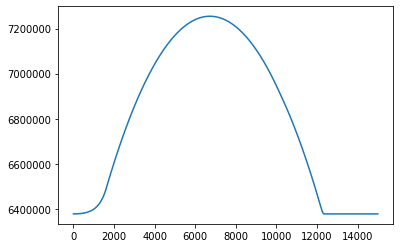

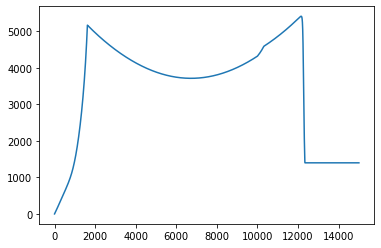

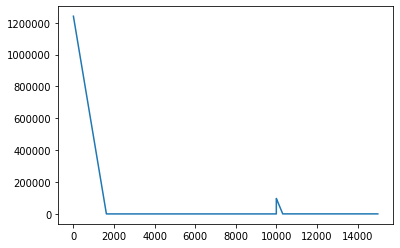

/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


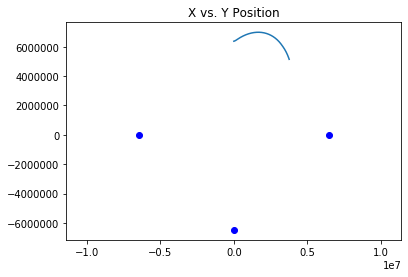

In [4]:
r = Rocket()

pt_vars = [r.rx, r.ry, r.vx, r.vy, r.fuelm]
t = 0
dt = 0.1
input_vars = [np.pi/4, 1, False] #ThrustAngle, throttle, stage

R = []
RX = []
RY = []
V = []
Fuel = []
T = []

for i in range(10000):
    pt_vars = r.RK4_step(pt_vars, dt, input_vars)
    rx, ry, vx, vy, fuelm = pt_vars
    R.append(np.sqrt(rx**2+ry**2))
    RX.append(rx)
    RY.append(ry)
    V.append(np.sqrt(vx**2+vy**2))
    Fuel.append(fuelm)
    T.append(i)
    
    
input_vars = [0, 1, True] #ThrustAngle, throttle, stage

for i in range(5000):
    t = i + 10000
    pt_vars = r.RK4_step(pt_vars, dt, input_vars)
    rx, ry, vx, vy, fuelm = pt_vars
    R.append(np.sqrt(rx**2+ry**2))
    RX.append(rx)
    RY.append(ry)
    V.append(np.sqrt(vx**2+vy**2))
    Fuel.append(fuelm)
    T.append(t)

    
plt.plot(T,R)
plt.show()
plt.plot(T,V)
plt.show()
plt.plot(T,Fuel)
plt.show()

karman = 6378000 + 100000
plt.plot(RX, RY)
plt.plot(0,-karman,'bo')
plt.plot(karman,0,'bo')
plt.plot(-karman,0,'bo')
plt.title("X vs. Y Position")
plt.axes().set_aspect('equal','datalim')
plt.show()